In [232]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [233]:
pd.set_option('display.max_columns', None)

In [234]:
features = pd.read_csv('./train_features.csv', header=0)
features.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,43373,NaN,12000,12000,36 months,16.02%,422.01,C,C5,Driver,4 years,MORTGAGE,81000.0,NaN,NaN,debt_consolidation,Debt consolidation,280xx,NC,12.76,0,Dec-2005,1,48.0,NaN,7,0,4912,23.5%,15,w,0,48.0,Individual,NaN,NaN,0,0,174783,1,2,0,4,13.0,33668,82.0,2,5,2962,63.0,20900,1,1,2,9,24969.0,588.0,89.3,0,0,145.0,23,1,1,1,8.0,NaN,1.0,NaN,2,2,2,2,2,9,4,5,2,7,0.0,0,0,2,92.9,100.0,0,0,206618,38580,5500,40863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,24414,NaN,6300,6300,36 months,14.07%,215.54,C,C3,GMP Lead,4 years,RENT,39000.0,NaN,NaN,debt_consolidation,Debt consolidation,920xx,CA,21.42,0,Mar-2012,1,NaN,NaN,10,0,11876,59.4%,12,w,0,NaN,Individual,NaN,NaN,0,0,31046,0,1,0,2,14.0,19170,83.0,3,8,5153,72.0,20000,1,0,1,10,3105.0,6877.0,59.3,0,0,17.0,72,8,8,0,8.0,NaN,6.0,NaN,0,6,7,7,8,2,9,10,7,10,0.0,0,0,3,100.0,42.9,0,0,43140,31046,16900,23140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,46723,NaN,4500,4500,36 months,7.21%,139.38,A,A3,Accounts,3 years,RENT,78000.0,NaN,NaN,debt_consolidation,Debt consolidation,906xx,CA,2.17,0,May-2000,2,NaN,NaN,13,0,1715,5.2%,19,w,0,NaN,Individual,NaN,NaN,0,0,35329,0,8,1,2,10.0,33614,106.0,1,1,1196,54.0,33300,4,0,3,3,2718.0,21585.0,7.4,0,0,166.0,218,10,10,0,31.0,NaN,1.0,NaN,0,3,3,3,4,13,5,6,3,13,0.0,0,0,2,100.0,0.0,0,0,65092,35329,23300,31792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,24878,NaN,12000,12000,36 months,9.44%,384.06,B,B1,Client Processing Associate,10+ years,MORTGAGE,62000.0,NaN,NaN,debt_consolidation,Debt consolidation,441xx,OH,13.76,0,Feb-2003,0,NaN,NaN,22,0,9404,16.3%,33,w,0,NaN,Individual,NaN,NaN,0,0,75160,4,1,0,2,13.0,17123,67.0,6,9,6898,32.0,57600,3,1,2,12,3579.0,33602.0,17.0,0,0,162.0,179,1,1,1,1.0,NaN,5.0,NaN,0,1,3,9,13,7,20,25,3,22,0.0,0,0,7,100.0,0.0,0,0,133065,26527,40500,25465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,39038,NaN,12000,12000,36 months,22.35%,460.47,D,D5,Construction Operator,10+ years,MORTGAGE,70000.0,NaN,NaN,debt_consolidation,Debt consolidation,751xx,TX,14.04,4,Nov-2001,2,13.0,NaN,18,0,17895,24.2%,45,w,0,13.0,Individual,NaN,NaN,0,7218,113702,9,2,2,4,6.0,16711,68.0,9,10,5373,35.0,73900,3,6,3,14,6317.0,32863.0,24.1,0,0,159.0,201,0,0,1,0.0,62.0,3.0,62.0,6,9,11,11,14,22,15,20,11,18,0.0,0,2,11,82.2,9.1,0,0,192842,34606,43300,24499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash


In [235]:
target = pd.read_csv('./train_labels.csv', header=0)
target.head()

,id,charged_off
0,43373,0
1,24414,0
2,46723,0
3,24878,0
4,39038,0


In [236]:
train = features.merge(target)
print('train.shape:', train.shape)
train.head()

train.shape: (37745, 104)


,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method,charged_off
0,43373,NaN,12000,12000,36 months,16.02%,422.01,C,C5,Driver,4 years,MORTGAGE,81000.0,NaN,NaN,debt_consolidation,Debt consolidation,280xx,NC,12.76,0,Dec-2005,1,48.0,NaN,7,0,4912,23.5%,15,w,0,48.0,Individual,NaN,NaN,0,0,174783,1,2,0,4,13.0,33668,82.0,2,5,2962,63.0,20900,1,1,2,9,24969.0,588.0,89.3,0,0,145.0,23,1,1,1,8.0,NaN,1.0,NaN,2,2,2,2,2,9,4,5,2,7,0.0,0,0,2,92.9,100.0,0,0,206618,38580,5500,40863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
1,24414,NaN,6300,6300,36 months,14.07%,215.54,C,C3,GMP Lead,4 years,RENT,39000.0,NaN,NaN,debt_consolidation,Debt consolidation,920xx,CA,21.42,0,Mar-2012,1,NaN,NaN,10,0,11876,59.4%,12,w,0,NaN,Individual,NaN,NaN,0,0,31046,0,1,0,2,14.0,19170,83.0,3,8,5153,72.0,20000,1,0,1,10,3105.0,6877.0,59.3,0,0,17.0,72,8,8,0,8.0,NaN,6.0,NaN,0,6,7,7,8,2,9,10,7,10,0.0,0,0,3,100.0,42.9,0,0,43140,31046,16900,23140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
2,46723,NaN,4500,4500,36 months,7.21%,139.38,A,A3,Accounts,3 years,RENT,78000.0,NaN,NaN,debt_consolidation,Debt consolidation,906xx,CA,2.17,0,May-2000,2,NaN,NaN,13,0,1715,5.2%,19,w,0,NaN,Individual,NaN,NaN,0,0,35329,0,8,1,2,10.0,33614,106.0,1,1,1196,54.0,33300,4,0,3,3,2718.0,21585.0,7.4,0,0,166.0,218,10,10,0,31.0,NaN,1.0,NaN,0,3,3,3,4,13,5,6,3,13,0.0,0,0,2,100.0,0.0,0,0,65092,35329,23300,31792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
3,24878,NaN,12000,12000,36 months,9.44%,384.06,B,B1,Client Processing Associate,10+ years,MORTGAGE,62000.0,NaN,NaN,debt_consolidation,Debt consolidation,441xx,OH,13.76,0,Feb-2003,0,NaN,NaN,22,0,9404,16.3%,33,w,0,NaN,Individual,NaN,NaN,0,0,75160,4,1,0,2,13.0,17123,67.0,6,9,6898,32.0,57600,3,1,2,12,3579.0,33602.0,17.0,0,0,162.0,179,1,1,1,1.0,NaN,5.0,NaN,0,1,3,9,13,7,20,25,3,22,0.0,0,0,7,100.0,0.0,0,0,133065,26527,40500,25465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
4,39038,NaN,12000,12000,36 months,22.35%,460.47,D,D5,Construction Operator,10+ years,MORTGAGE,70000.0,NaN,NaN,debt_consolidation,Debt consolidation,751xx,TX,14.04,4,Nov-2001,2,13.0,NaN,18,0,17895,24.2%,45,w,0,13.0,Individual,NaN,NaN,0,7218,113702,9,2,2,4,6.0,16711,68.0,9,10,5373,35.0,73900,3,6,3,14,6317.0,32863.0,24.1,0,0,159.0,201,0,0,1,0.0,62.0,3.0,62.0,6,9,11,11,14,22,15,20,11,18,0.0,0,2,11,82.2,9.1,0,0,192842,34606,43300,24499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0


In [237]:
target_encoder_params = None
target_encoder_mappings = None

In [278]:
def create_mappings(X, X_transformed):
    
    d = {}
    cols = X.select_dtypes(include='object').columns
    for col in cols:
        print(col)
        d2 = {}
        d[col] = d2
        ori_col = X[col]
        trans_col = X_transformed[col]
        for i in range(len(X)):
            d2[ori_col[i]] = trans_col[i]
    print('number of mappings:', len(d))
    return d

def apply_mappings(X, d):

    cols = X.select_dtypes(include='object').columns
    for col in cols:
        print(col)
        d2 = d[col]
        ori_col = X[col]
        trans_col = []
        for i in range(len(X)):
            res = d2.get(ori_col[i], None)
            if res == None:
                trans_col.append(None)
            else:
                trans_col.append(res if ori_col[i] != None else None)
        X[col] = trans_col

def wrangle(d, type_of_data='train'):
    def sub_grade_to_float(x):
        return float(ord(x[0]) - 64) + float(x[1:]) / 10
    
    global target_encoder_params
    global target_encoder_mappings

    df = d.copy()
    df.sub_grade = df.sub_grade.apply(sub_grade_to_float)
    df.int_rate = df.int_rate.apply(lambda x: float(x.strip()[:-1]))
    df.dti = df.dti.fillna(df.dti.median())
    df.all_util = df.all_util.fillna(df.all_util.median())
    df.avg_cur_bal = df.avg_cur_bal.fillna(df.avg_cur_bal.median())
    df.zip_code = df.zip_code.apply(lambda x: int(x[:3]))
    
    # A nan value is considered a float, so if there are nan values
    # in any feature that is not float, you have to process those
    # values specially, before you can process the non-nan values.
    # Instead, you can create a loop and an if statement to process
    # each value depending on it's type.
    res = []
    for i in range(len(df.revol_util)):
        if isinstance(df.revol_util[i], float):
            res.append(0.0)
        else:
            res.append(float(df.revol_util[i].strip('%')))
    df.revol_util = res
    df.application_type = (df.application_type == 'Joint App').astype(int)
    
    # Always apply target encoder at the end, because it will
    # apply target encoding unnecessarily to columns that are strings,
    # which you will overwrite later in the wrangle process.
    target_encoder = ce.target_encoder.TargetEncoder( \
                                        return_df=True, \
                                         drop_invariant=False, \
                                         handle_unknown='ignore')
    if type_of_data == 'train':
        X = df.drop('charged_off', axis=1)
        y = df['charged_off']
        X_transformed = target_encoder.fit_transform(X, y)
        target_encoder_params = target_encoder.get_params(deep=True)
        X_transformed['charged_off'] = df['charged_off']
        target_encoder_mappings = create_mappings(X, X_transformed)
        df = X_transformed
    else:
        print('Applying target encoder params/mappings')
        apply_mappings(df, target_encoder_mappings)
#         if target_encoder_params is not None:
#             target_encoder.set_params(target_encoder_params)
    
    return df

In [239]:
def SHAP_impact_on_model_output(X_train, X_val, y_train, y_val, model):
    shap.initjs()

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap.summary_plot(shap_values, X_val)
    shap.summary_plot(shap_values, X_val, plot_type="bar")


def split_data(df, target, include_features,
               test_size=0.2):
    
    if isinstance(include_features, str):
        df_lim_features = df.select_dtypes(include=include_features)
    else:  # must be a list of features we selected
        df_lim_features = df.loc[:, include_features]
        
    print('Limited features df:', df_lim_features.shape)
    print(df_lim_features.head(), end='\n\n')
    if target in df_lim_features.columns:
        X = df_lim_features.drop(target, axis=1)
        y = df_lim_features[target]
    else:  # When features are categorical, but target is numerical or vice versa
        X = df_lim_features
        y = df[target]
        
    X_train, X_val, y_train, y_val = train_test_split(
                                        X, y, test_size=0.2,
                                        random_state=20)
    return X_train, X_val, y_train, y_val

In [240]:
def feature_rankings(df, target, clf, include_features):
    X_train, X_val, y_train, y_val = \
        split_data(df, target, include_features=include_features, test_size=0.2)

    # Now there are no categorical variables at this point.
    # So no need for this.
    # encoder = ce.OrdinalEncoder()
    # X_train = encoder.fit_transform(X_train)
    # X_val = encoder.transform(X_val)
    model = clf.fit(X_train, y_train)
    
    print('Classifier score:', model.score(X_val, y_val))
    SHAP_impact_on_model_output(X_train, X_val, y_train, y_val, model)

term
grade
emp_title
emp_length
home_ownership
purpose
title
addr_state
earliest_cr_line
initial_list_status
sec_app_earliest_cr_line
disbursement_method
number of mappings: 12
Limited features df: (37745, 104)
      id  member_id  loan_amnt  funded_amnt      term  int_rate  installment  \
0  43373        NaN      12000        12000  0.125546     16.02       422.01   
1  24414        NaN       6300         6300  0.125546     14.07       215.54   
2  46723        NaN       4500         4500  0.125546      7.21       139.38   
3  24878        NaN      12000        12000  0.125546      9.44       384.06   
4  39038        NaN      12000        12000  0.125546     22.35       460.47   

      grade  sub_grade  emp_title  emp_length  home_ownership  annual_inc  \
0  0.172648        3.5   0.173913    0.154825        0.109818     81000.0   
1  0.172648        3.3   0.147145    0.154825        0.194829     39000.0   
2  0.049751        1.3   0.147145    0.157534        0.194829     78000.0   


Classifier score: 0.8663399125712015


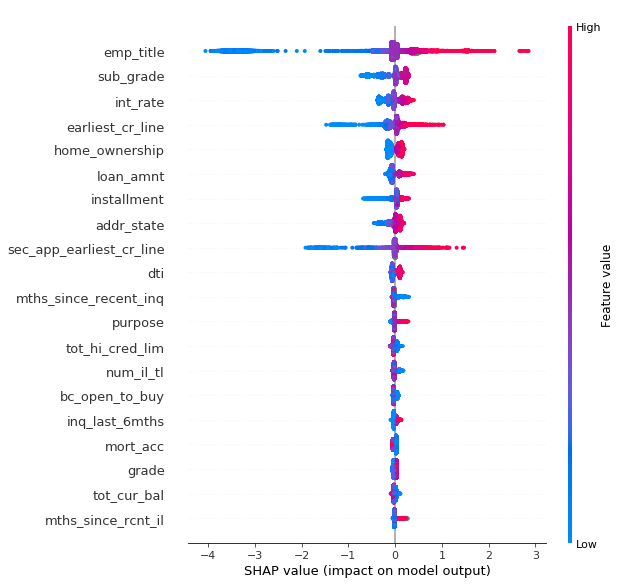

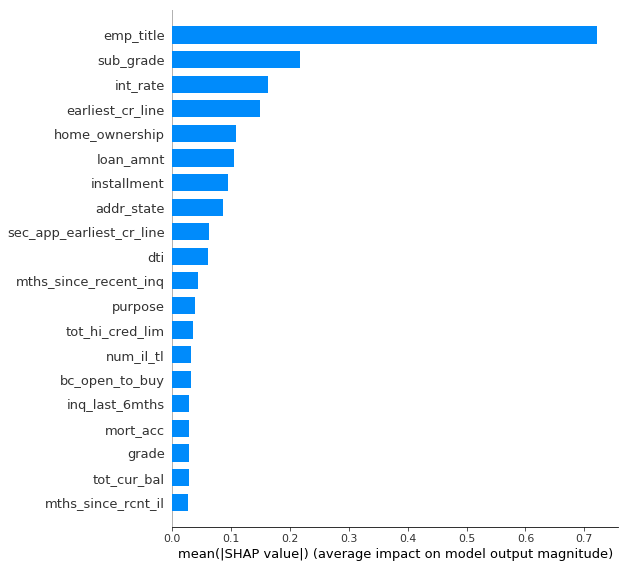

In [241]:
df_train = wrangle(train, type_of_data='train')

xgb = XGBClassifier()
feature_rankings(df_train, 'charged_off', xgb, 'number')

# The target encoder in wrangle() has converted all remaining categorical
# variables to numerical. This dataframe then does not have any columns.
# So, nothing to do here.
# feature_rankings(df_train, 'charged_off', xgb, 'object')

### The red values in this plot says that the value of that feature is high. For the top feature (tot_hi_cred_lim), the red spots are to the left of the median line. This means this feature being high moves the output towards lesser values (i.e. towards 0 or paid off rather than 1 which is charged-off).
### We can also plot the mean absolute SHAP values as shown below

In [242]:
print(target_encoder_mappings)

{'term': {' 36 months': 0.12554585152838427, ' 60 months': 0.20496833901607403}, 'grade': {'C': 0.17264801297648014, 'A': 0.0497506530515317, 'B': 0.10607531055900621, 'D': 0.2445966514459665, 'E': 0.27012609117361785, 'F': 0.32018561484918795, 'G': 0.40217391304347827}, 'emp_title': {'Driver': 0.17391304347826086, 'GMP Lead': 0.14714531726056432, 'Accounts ': 0.14714531726056432, 'Client Processing Associate': 0.14714531726056432, 'Construction Operator ': 0.14714531726056432, 'AML aNalyst ': 0.14714531726056432, nan: nan, 'E-7': 0.017540151779330816, 'Regional Sales Director': 0.017540151779330816, 'owner': 0.3, 'Director': 0.07633587786259542, 'Assistant Branch Manager': 0.00697849515507233, 'Senior Loan Officer': 0.24512202686068066, 'Program Manager': 0.04, 'Manager': 0.16984126984126985, 'Senior Analyst': 0.2221970451723483, 'Collector': 0.0026465865711870836, 'Welder': 0.20588235294117618, 'Dealer': 0.07692350838078252, 'Operations Manager': 0.1326530612244898, 'Cashier': 0.2368

In [284]:
print(target_encoder_params)

{'cols': ['term', 'grade', 'emp_title', 'emp_length', 'home_ownership', 'purpose', 'title', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'sec_app_earliest_cr_line', 'disbursement_method'], 'drop_invariant': False, 'handle_unknown': 'ignore', 'impute_missing': True, 'min_samples_leaf': 1, 'return_df': True, 'smoothing': 1.0, 'verbose': 0}


In [243]:
# use_cols = ['emp_title', 'sub_grade', 'int_rate', 'earliest_cr_line',
#             'home_ownership', 'loan_amnt', 'installment', 'addr_state',
#             'sec_app_earliest_cr_line', 'dti', 'mnths_since_recent_inq',
#             'purpose', 'tot_hi_cred_lim', 'num_il_tl', 'bc_open_to_buy',
#             'inq_last_6mths', 'mort_acc', 'grade', 'tot_cur_bal',
#             'mths_since_rcnt_il']
# xgb = XGBClassifier()
# feature_rankings(df_train, 'charged_off', xgb, use_cols)

### Can't get beyond 85%. Maybe we should change tactics and look at correlation between features and Seaborn pairplots

#### Select the top correlated numerical features

In [244]:
# df_train = wrangle(train)
# df_numerical = df_train.select_dtypes(include='number')
# use_numerical_cols = abs(df_numerical.corr()['charged_off'][:]) \
#                          .sort_values(ascending=False).index

#### Visually select the most correlated categorical features

In [245]:
# x_vars=df_train.drop(['charged_off'], axis=1) \
#             .loc[:, df_train.columns.difference(use_numerical_cols)] \
#             .columns.values
# x_vars

In [246]:
# type(list(x_vars))
# type(list(['charged_off']))
# sns.pairplot(train, x_vars=list(x_vars), y_vars=['charged_off'])

#### For some reason, pairplot could not be drawn even after 10 minutes. Maybe I need to wait a lot more because we have a lot more data points. Will try again when I have more time.

### Split the dataset into training and validation sets

In [247]:
X_train, X_val, y_train, y_val = \
    train_test_split(df_train.drop(['charged_off'], axis=1), 
                     df_train['charged_off'], 
                     test_size=0.2, random_state=20)

### Go through a sequence of steps to find the best XGBoost classifier. The steps based on [this blogpost](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e) are:
1. Fill reasonable values for key inputs:
learning_rate: 0.01
n_estimators: 100 if the size of your data is high, 1000 is if it is medium-low
max_depth: 3
subsample: 0.8
colsample_bytree: 1
gamma: 1
2. Run model.fit(eval_set, eval_metric) and diagnose your first run, specifically the n_estimators parameter
3. Optimize max_depth parameter. It represents the depth of each tree, which is the maximum number of different features used in each tree. I recommend going from a low max_depth (3 for instance) and then increasing it incrementally by 1, and stopping when there’s no performance gain of increasing it. This will help simplify your model and avoid overfitting
4. Now play around with the learning rate and the features that avoids overfitting:
learning_rate: usually between 0.1 and 0.01. If you’re focused on performance and have time in front of you, decrease incrementally the learning rate while increasing the number of trees.
subsample, which is for each tree the % of rows taken to build the tree. I recommend not taking out too many rows, as performance will drop a lot. Take values from 0.8 to 1.
colsample_bytree: number of columns used by each tree. In order to avoid some columns to take too much credit for the prediction (think of it like in recommender systems when you recommend the most purchased products and forget about the long tail), take out a good proportion of columns. Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
gamma: usually misunderstood parameter, it acts as a regularization parameter. Either 0, 1 or 5.

#### Step 1/2

In [248]:
model = XGBClassifier(learning_rate=0.01, n_estimators=1000, max_depth=3, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.865280169558882

In [249]:
model = XGBClassifier(learning_rate=0.01, n_estimators=500, max_depth=3, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8638230229169427

#### Step 2/3

In [250]:
model = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.860908729633064

In [251]:
model = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=4, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8619684726453835

In [252]:
model = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=5, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8622334083984634

In [253]:
model = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=6, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8624983441515433

In [254]:
model = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=7, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8643528944231024

#### Step 4

In [255]:
model = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8667373162008213

In [256]:
model = XGBClassifier(learning_rate=0.50, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8632931514107829

In [257]:
model = XGBClassifier(learning_rate=0.75, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8575970327195656

In [258]:
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8632931514107829

In [259]:
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=0.9, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8648827659292622

In [260]:
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=1.0, colsample_bytree=1, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.865147701682342

In [261]:
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.3, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8638230229169427

In [262]:
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.5, gamma=1)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8650152338058021

In [263]:
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.3, gamma=5)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8664723804477414

In [264]:
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.3, gamma=0)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8656775731885018

### Use grid search to find the optimal XGBoost classifier

#### Base the param_grid on these parameters (based on our results above):
model = XGBClassifier(learning_rate=0.5, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.3, gamma=5)

In [265]:
# encoder = ce.OrdinalEncoder()
# X_train = encoder.fit_transform(X_train)
# X_val = encoder.transform(X_val)
# model = clf.fit(X_train, y_train)

param_grid = {
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators':  [80, 100, 120],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.3, 0.4],
    'gamma': [4, 5]
}

gridsearch = GridSearchCV(XGBClassifier(),
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, n_jobs=-1,
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.04, 0.05, 0.06], 'n_estimators': [80, 100, 120], 'max_depth': [3, 4], 'subsample': [0.8, 0.9], 'colsample_bytree': [0.3, 0.4], 'gamma': [4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [266]:
# To get the best score grid search got:
#   gridsearch.best_score_
# To find the best model grid search found:
#   gridsearch.cv_results_['params'][gridsearch.best_index_]

In [267]:
print('  Best score from grid search:', gridsearch.score(X_train, y_train))

  Best score from grid search: 0.8679295270896807


In [268]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
142,5.961787,0.357105,0.082646,0.006061,0.4,5,0.06,4,120,0.8,"{'colsample_bytree': 0.4, 'gamma': 5, 'learnin...",0.861812,0.862991,0.860705,0.861836,0.000933,1,0.871138,0.868462,0.871641,0.870413,0.001395
106,7.688100,0.141661,0.101930,0.000641,0.4,4,0.06,4,120,0.8,"{'colsample_bytree': 0.4, 'gamma': 4, 'learnin...",0.862110,0.861997,0.860805,0.861637,0.000590,2,0.871187,0.868909,0.871541,0.870546,0.001167
34,5.515175,0.062430,0.105748,0.001334,0.3,4,0.06,4,120,0.8,"{'colsample_bytree': 0.3, 'gamma': 4, 'learnin...",0.861713,0.862295,0.860407,0.861472,0.000789,3,0.869796,0.868263,0.871492,0.869850,0.001319
107,7.215443,0.044502,0.104007,0.005938,0.4,4,0.06,4,120,0.9,"{'colsample_bytree': 0.4, 'gamma': 4, 'learnin...",0.859924,0.862891,0.860705,0.861174,0.001256,4,0.870939,0.869058,0.871293,0.870430,0.000981
143,5.315647,0.080632,0.071832,0.001245,0.4,5,0.06,4,120,0.9,"{'colsample_bytree': 0.4, 'gamma': 5, 'learnin...",0.860322,0.862295,0.860606,0.861074,0.000871,5,0.871088,0.868710,0.870846,0.870215,0.001069
140,5.674789,0.015240,0.088650,0.001899,0.4,5,0.06,4,100,0.8,"{'colsample_bytree': 0.4, 'gamma': 5, 'learnin...",0.860620,0.861600,0.860407,0.860876,0.000519,6,0.869449,0.866574,0.868660,0.868228,0.001213
131,6.641766,0.012267,0.102251,0.002032,0.4,5,0.05,4,120,0.9,"{'colsample_bytree': 0.4, 'gamma': 5, 'learnin...",0.860819,0.861798,0.859911,0.860842,0.000771,7,0.868753,0.866375,0.868760,0.867963,0.001122
70,5.373775,0.011946,0.106652,0.005715,0.3,5,0.06,4,120,0.8,"{'colsample_bytree': 0.3, 'gamma': 5, 'learnin...",0.861117,0.861401,0.859712,0.860743,0.000738,8,0.870541,0.867766,0.870747,0.869685,0.001359
130,6.685430,0.018040,0.102585,0.003245,0.4,5,0.05,4,120,0.8,"{'colsample_bytree': 0.4, 'gamma': 5, 'learnin...",0.860620,0.861003,0.860308,0.860644,0.000284,9,0.868505,0.865829,0.868412,0.867582,0.001240
68,4.408024,0.017484,0.089934,0.002384,0.3,5,0.06,4,100,0.8,"{'colsample_bytree': 0.3, 'gamma': 5, 'learnin...",0.860123,0.861003,0.860705,0.860611,0.000366,10,0.867660,0.865133,0.867915,0.866903,0.001256


In [269]:
gridsearch.cv_results_['params'][gridsearch.best_index_]

{'colsample_bytree': 0.4,
 'gamma': 5,
 'learning_rate': 0.06,
 'max_depth': 4,
 'n_estimators': 120,
 'subsample': 0.8}

In [270]:
clf = XGBClassifier(colsample_bytree=0.4, gamma=5, learning_rate=0.06,
                    max_depth=4, n_estimators=120, subsample=0.8)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.8639554907934826

In [271]:
test = pd.read_csv('./test_features.csv', header=0)
test.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,57146,NaN,18500,18500,60 months,25.82%,551.93,E,E4,Account Service Representative,10+ years,MORTGAGE,87000.0,NaN,NaN,debt_consolidation,Debt consolidation,452xx,OH,22.07,0,Jun-2007,3,NaN,111.0,20,1,5504,16.9%,37,w,0,NaN,Individual,NaN,NaN,0,200,212122,2,5,4,6,1.0,105151,88.0,2,3,2991,66.0,32500,6,3,12,10,10606.0,16813.0,23.9,0,0,127.0,55,7,1,2,8.0,NaN,1.0,NaN,0,4,5,8,9,20,14,15,5,20,0.0,0,0,6,100.0,0.0,1,0,250214,110655,22100,113624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,20988,NaN,36000,36000,60 months,12.61%,811.95,C,C1,Vice President of IT,7 years,MORTGAGE,165000.0,NaN,NaN,other,Other,480xx,MI,13.39,0,Oct-1992,0,31.0,NaN,12,0,21833,42.6%,21,w,0,NaN,Individual,NaN,NaN,0,0,42059,2,2,1,2,6.0,20226,56.0,1,3,5880,48.0,51200,1,0,1,5,3505.0,19340.0,41.4,0,0,304.0,131,4,4,0,15.0,31.0,6.0,31.0,0,3,7,6,6,6,10,14,7,12,0.0,0,0,2,85.7,16.7,0,0,87584,42059,33000,36384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,10031,NaN,12000,12000,36 months,22.90%,463.90,E,E1,Director of Technology,4 years,MORTGAGE,110000.0,NaN,NaN,debt_consolidation,Debt consolidation,972xx,OR,15.82,1,Dec-2004,0,7.0,NaN,4,0,19930,97.2%,11,f,0,NaN,Individual,NaN,NaN,0,0,170912,0,1,1,1,8.0,25739,86.0,0,0,10385,90.0,20500,0,0,0,1,42728.0,570.0,97.2,0,0,130.0,162,42,8,2,42.0,NaN,19.0,NaN,0,2,2,2,3,4,2,5,2,4,0.0,0,0,1,81.8,100.0,0,0,210150,45669,20500,30000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,33892,NaN,24875,24875,60 months,11.98%,553.08,B,B5,vp,10+ years,MORTGAGE,105000.0,NaN,NaN,other,Other,463xx,IN,6.91,0,Nov-1995,1,NaN,NaN,7,0,29537,47.3%,24,w,0,NaN,Individual,NaN,NaN,0,0,507349,0,0,0,1,18.0,0,NaN,0,1,12097,47.0,62400,1,1,2,3,84558.0,27863.0,51.5,0,0,126.0,268,22,15,3,65.0,NaN,4.0,NaN,0,4,4,5,7,9,6,12,4,7,0.0,0,0,0,100.0,25.0,0,0,547400,29537,57400,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,35374,NaN,4000,4000,36 months,10.91%,130.79,B,B4,Sales consultant,< 1 year,MORTGAGE,20000.0,NaN,NaN,other,Other,705xx,LA,69.96,0,Sep-2003,0,NaN,NaN,16,0,5863,18.8%,28,w,0,NaN,Joint App,66000.0,32.72,0,0,169662,1,2,1,2,10.0,43585,85.0,0,4,1013,46.0,31200,10,2,5,7,10604.0,4533.0,37.9,0,0,159.0,53,19,2,2,22.0,NaN,4.0,NaN,0,6,10,6,7,12,13,14,10,16,0.0,0,0,2,100.0,0.0,0,0,209852,49448,7300,58652,6169.0,Sep-2003,0.0,2.0,7.0,22.9,3.0,3.0,0.0,0.0,NaN,Cash


In [272]:
test.shape

(9437, 103)

In [279]:
X = wrangle(test, type_of_data='test')

Applying target encoder params/mappings
term
grade
emp_title
emp_length
home_ownership
purpose
title
addr_state
earliest_cr_line
initial_list_status
sec_app_earliest_cr_line
disbursement_method


In [280]:
y_pred = clf.predict_proba(X)[:, 1]

In [282]:
res = pd.DataFrame(data={'id': test.id.values, 'charged_off': y_pred})
res.head()

,id,charged_off
0,57146,0.207681
1,20988,0.290932
2,10031,0.010700
3,33892,0.009553
4,35374,0.010136


In [283]:
res.to_csv('./y_pred.csv', header=True, index=False)